Variational Auto-Encoder (VAE)
=====

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class VAE(nn.Module):
    def __init__(
            self,
            input_channels=1,
            input_dim=784,
            hidden_dim=400,
            latent_dim=20,
            use_conv=False
        ):
        super().__init__()
        self.use_conv = use_conv
        if use_conv:
            self.encoder = nn.Sequential(
                nn.Conv2d(input_channels, 32, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.Conv2d(64, 128, kernel_size=7, stride=2, padding=0),
                nn.LeakyReLU(),
                nn.Flatten(),
            )
            self.fc_mu = nn.Linear(128, latent_dim)
            self.fc_logvar = nn.Linear(128, latent_dim)
            self.fc_decode = nn.Linear(latent_dim, 128)
            self.decoder = nn.Sequential(
                nn.Unflatten(1, (128, 1, 1)),
                nn.ConvTranspose2d(128, 64, kernel_size=7, stride=1, padding=0),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),
                nn.Sigmoid()
            )
        else:
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.LeakyReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU()
            )
            self.fc_mu = nn.Linear(hidden_dim, latent_dim)
            self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
            self.decoder = nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.LeakyReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(),
                nn.Linear(hidden_dim, input_dim),
                nn.Sigmoid()
            )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def encode(self, x):
        if self.use_conv:
            h = self.encoder(x)
        else:
            h = self.encoder(x.view(x.size(0), -1))
        mu, logvar = self.fc_mu(h), self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
    
    def decode(self, z):
        if self.use_conv:
            h = self.fc_decode(z)
            h = h.view(h.size(0), 128, 1, 1)
        else:
            h = z
        x_recon = self.decoder(h)
        if not self.use_conv:
            x_recon = x_recon.view(x_recon.size(0), 1, 28, 28)
        return x_recon

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, mu, logvar
    
    def loss_function(self, x, x_recon, mu, logvar):
        #recon_loss = nn.functional.mse_loss(x_recon, x, reduction='sum')
        recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_loss
        



In [3]:
model = VAE(input_channels=1, latent_dim=20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# test a forward pass
x = torch.randn(16, 1, 28, 28).to(device)
x_recon, mu, logvar = model(x)
print(f"Input shape: {x.shape}")
print(f"Reconstructed shape: {x_recon.shape}")
print(f"Latent mu shape: {mu.shape}")
print(f"Latent logvar shape: {logvar.shape}")

Input shape: torch.Size([16, 1, 28, 28])
Reconstructed shape: torch.Size([16, 1, 28, 28])
Latent mu shape: torch.Size([16, 20])
Latent logvar shape: torch.Size([16, 20])


In [4]:
# setup hyperparameter, dataset and dataloader
batch_size = 128
learning_rate = 1e-3
num_epochs = 50


#transform = transforms.Compose([
#    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))
#])
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(
    root='./data', train=True,
    transform=transform, download=True
)
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

In [5]:
# dryrun: forward pass and calculate loss
batch = next(iter(train_loader))
images, _ = batch
images = images.to(device)
print(f"Input shape: {images.shape}")
x_recon, mu, logvar = model(images)
print(f"Reconstructed shape: {x_recon.shape}")
loss = model.loss_function(images, x_recon, mu, logvar)
print(f"Loss: {loss.item()}")

Input shape: torch.Size([128, 1, 28, 28])
Reconstructed shape: torch.Size([128, 1, 28, 28])
Loss: 69595.3359375


In [6]:
# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training loop
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, _ = batch
        images = images.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(images)
        loss = model.loss_function(images, x_recon, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch 1/50: 100%|██████████| 469/469 [00:02<00:00, 214.49it/s]


Epoch [1/50], Loss: 172.9761


Epoch 2/50: 100%|██████████| 469/469 [00:02<00:00, 222.72it/s]


Epoch [2/50], Loss: 124.8611


Epoch 3/50: 100%|██████████| 469/469 [00:02<00:00, 226.50it/s]


Epoch [3/50], Loss: 115.7211


Epoch 4/50: 100%|██████████| 469/469 [00:02<00:00, 226.29it/s]


Epoch [4/50], Loss: 112.1930


Epoch 5/50: 100%|██████████| 469/469 [00:02<00:00, 226.27it/s]


Epoch [5/50], Loss: 109.7626


Epoch 6/50: 100%|██████████| 469/469 [00:02<00:00, 226.43it/s]


Epoch [6/50], Loss: 108.0382


Epoch 7/50: 100%|██████████| 469/469 [00:02<00:00, 225.67it/s]


Epoch [7/50], Loss: 106.6336


Epoch 8/50: 100%|██████████| 469/469 [00:02<00:00, 228.91it/s]


Epoch [8/50], Loss: 105.4443


Epoch 9/50: 100%|██████████| 469/469 [00:02<00:00, 229.10it/s]


Epoch [9/50], Loss: 104.3876


Epoch 10/50: 100%|██████████| 469/469 [00:02<00:00, 232.01it/s]


Epoch [10/50], Loss: 103.6570


Epoch 11/50: 100%|██████████| 469/469 [00:02<00:00, 228.79it/s]


Epoch [11/50], Loss: 102.9848


Epoch 12/50: 100%|██████████| 469/469 [00:02<00:00, 223.00it/s]


Epoch [12/50], Loss: 102.4057


Epoch 13/50: 100%|██████████| 469/469 [00:02<00:00, 221.60it/s]


Epoch [13/50], Loss: 101.8482


Epoch 14/50: 100%|██████████| 469/469 [00:02<00:00, 226.82it/s]


Epoch [14/50], Loss: 101.4298


Epoch 15/50: 100%|██████████| 469/469 [00:02<00:00, 227.51it/s]


Epoch [15/50], Loss: 100.9815


Epoch 16/50: 100%|██████████| 469/469 [00:02<00:00, 227.12it/s]


Epoch [16/50], Loss: 100.6347


Epoch 17/50: 100%|██████████| 469/469 [00:02<00:00, 227.48it/s]


Epoch [17/50], Loss: 100.3789


Epoch 18/50: 100%|██████████| 469/469 [00:02<00:00, 227.41it/s]


Epoch [18/50], Loss: 100.0715


Epoch 19/50: 100%|██████████| 469/469 [00:02<00:00, 227.40it/s]


Epoch [19/50], Loss: 99.8115


Epoch 20/50: 100%|██████████| 469/469 [00:02<00:00, 221.76it/s]


Epoch [20/50], Loss: 99.5488


Epoch 21/50: 100%|██████████| 469/469 [00:02<00:00, 225.60it/s]


Epoch [21/50], Loss: 99.3691


Epoch 22/50: 100%|██████████| 469/469 [00:02<00:00, 219.03it/s]


Epoch [22/50], Loss: 99.1765


Epoch 23/50: 100%|██████████| 469/469 [00:02<00:00, 226.28it/s]


Epoch [23/50], Loss: 99.0549


Epoch 24/50: 100%|██████████| 469/469 [00:02<00:00, 225.56it/s]


Epoch [24/50], Loss: 98.8339


Epoch 25/50: 100%|██████████| 469/469 [00:02<00:00, 222.62it/s]


Epoch [25/50], Loss: 98.6841


Epoch 26/50: 100%|██████████| 469/469 [00:02<00:00, 223.52it/s]


Epoch [26/50], Loss: 98.5260


Epoch 27/50: 100%|██████████| 469/469 [00:02<00:00, 225.69it/s]


Epoch [27/50], Loss: 98.4049


Epoch 28/50: 100%|██████████| 469/469 [00:02<00:00, 220.98it/s]


Epoch [28/50], Loss: 98.2610


Epoch 29/50: 100%|██████████| 469/469 [00:02<00:00, 218.57it/s]


Epoch [29/50], Loss: 98.1451


Epoch 30/50: 100%|██████████| 469/469 [00:02<00:00, 222.46it/s]


Epoch [30/50], Loss: 98.0222


Epoch 31/50: 100%|██████████| 469/469 [00:02<00:00, 219.16it/s]


Epoch [31/50], Loss: 97.9234


Epoch 32/50: 100%|██████████| 469/469 [00:02<00:00, 218.30it/s]


Epoch [32/50], Loss: 97.7889


Epoch 33/50: 100%|██████████| 469/469 [00:02<00:00, 218.83it/s]


Epoch [33/50], Loss: 97.6506


Epoch 34/50: 100%|██████████| 469/469 [00:02<00:00, 218.52it/s]


Epoch [34/50], Loss: 97.5948


Epoch 35/50: 100%|██████████| 469/469 [00:02<00:00, 218.39it/s]


Epoch [35/50], Loss: 97.5441


Epoch 36/50: 100%|██████████| 469/469 [00:02<00:00, 219.40it/s]


Epoch [36/50], Loss: 97.4658


Epoch 37/50: 100%|██████████| 469/469 [00:02<00:00, 219.66it/s]


Epoch [37/50], Loss: 97.3457


Epoch 38/50: 100%|██████████| 469/469 [00:02<00:00, 222.83it/s]


Epoch [38/50], Loss: 97.2443


Epoch 39/50: 100%|██████████| 469/469 [00:02<00:00, 222.31it/s]


Epoch [39/50], Loss: 97.2230


Epoch 40/50: 100%|██████████| 469/469 [00:02<00:00, 218.53it/s]


Epoch [40/50], Loss: 97.1438


Epoch 41/50: 100%|██████████| 469/469 [00:02<00:00, 222.98it/s]


Epoch [41/50], Loss: 97.0322


Epoch 42/50: 100%|██████████| 469/469 [00:02<00:00, 218.91it/s]


Epoch [42/50], Loss: 96.9764


Epoch 43/50: 100%|██████████| 469/469 [00:02<00:00, 220.15it/s]


Epoch [43/50], Loss: 96.8979


Epoch 44/50: 100%|██████████| 469/469 [00:02<00:00, 223.21it/s]


Epoch [44/50], Loss: 96.8838


Epoch 45/50: 100%|██████████| 469/469 [00:02<00:00, 219.23it/s]


Epoch [45/50], Loss: 96.7243


Epoch 46/50: 100%|██████████| 469/469 [00:02<00:00, 218.48it/s]


Epoch [46/50], Loss: 96.6620


Epoch 47/50: 100%|██████████| 469/469 [00:02<00:00, 219.55it/s]


Epoch [47/50], Loss: 96.6526


Epoch 48/50: 100%|██████████| 469/469 [00:02<00:00, 218.42it/s]


Epoch [48/50], Loss: 96.5949


Epoch 49/50: 100%|██████████| 469/469 [00:02<00:00, 223.78it/s]


Epoch [49/50], Loss: 96.5212


Epoch 50/50: 100%|██████████| 469/469 [00:02<00:00, 220.37it/s]

Epoch [50/50], Loss: 96.4663


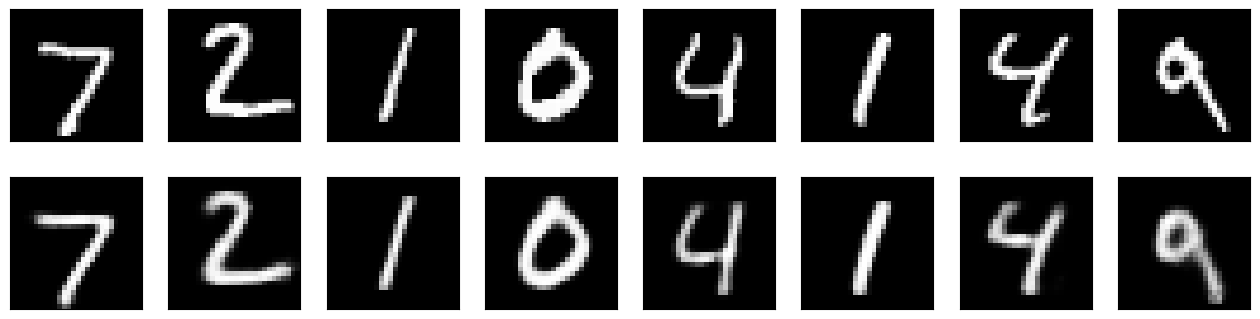

In [7]:
# Evaluate reconstruction
test_dataset = datasets.MNIST(
    root='./data', train=False,
    transform=transform, download=True
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

model.eval()
with torch.no_grad():
    batch = next(iter(test_loader))
    images, _ = batch
    images = images.to(device)
    x_recon, _, _ = model(images)
    x_recon = x_recon.cpu()
    images = images.cpu()
    # Plot original and reconstructed images
    n = 8
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_recon[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Sampled shape: torch.Size([16, 1, 28, 28]) (0.0, 0.9981220364570618)


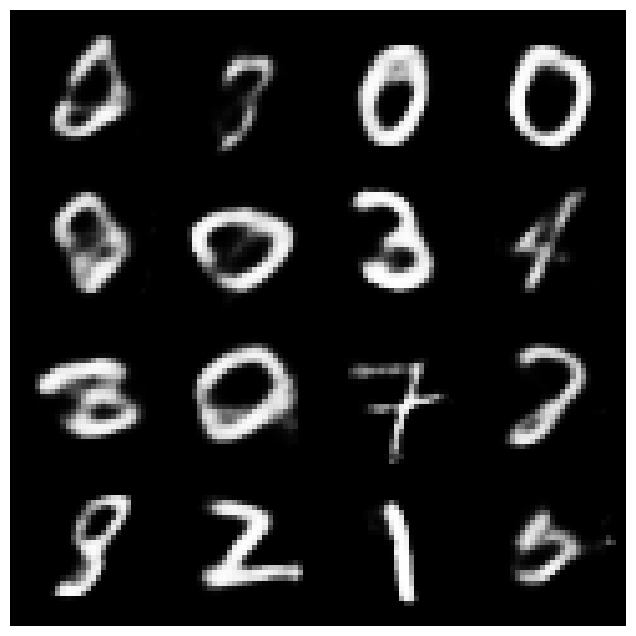

In [8]:
# sample from the trained model
model.eval()
with torch.no_grad():
    z = torch.randn(16, 20).to(device)
    samples = model.decode(z)
print(f"Sampled shape: {samples.shape} {(samples.min().item(), samples.max().item())}")
samples = torch.sigmoid(samples).cpu()
samples = samples.cpu()

# display the samples
grid = torchvision.utils.make_grid(samples, nrow=4, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray_r')
plt.axis('off')
plt.show()

Interpolated shape: torch.Size([10, 1, 28, 28])


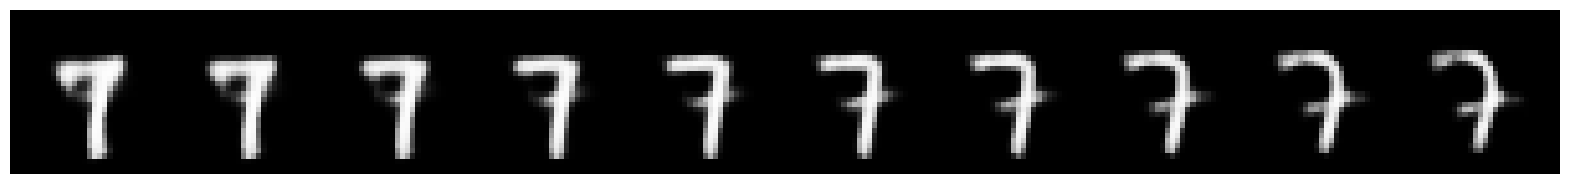

In [9]:
# latent space interpolation
model.eval()
with torch.no_grad():
    z1 = torch.randn(1, 20).to(device)
    z2 = torch.randn(1, 20).to(device)
    n_steps = 10
    interpolated = []
    for alpha in torch.linspace(0, 1, n_steps):
        z = (1 - alpha) * z1 + alpha * z2
        sample = model.decode(z)
        interpolated.append(sample.cpu())
    interpolated = torch.cat(interpolated, dim=0)
print(f"Interpolated shape: {interpolated.shape}")
# display the interpolated samples
grid = torchvision.utils.make_grid(interpolated, nrow=n_steps, normalize=True)
plt.figure(figsize=(20, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='gray_r')
plt.axis('off')
plt.show()